# Stock Price Prediction From Employee / Job Market Information
## Modelling: Neural Network
Objective build a neural network to model stock price changes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob

# Utilities
from utils import *

# plt.style.use('fivethirtyeight')

%matplotlib inline
PATH = Path(r'D:\data\jobs')

In [3]:
%%capture
link, companies, stocks = data_load(PATH)

## Data Load: USA Truck Inc.
Modelling for USA Truck Inc.

In [4]:
USAK = stocks.USAK
USAK_link = link[link['dataset_id']==929840]['employees_on_platform']

In [5]:
start = min(USAK_link.index)
end = max(USAK_link.index)

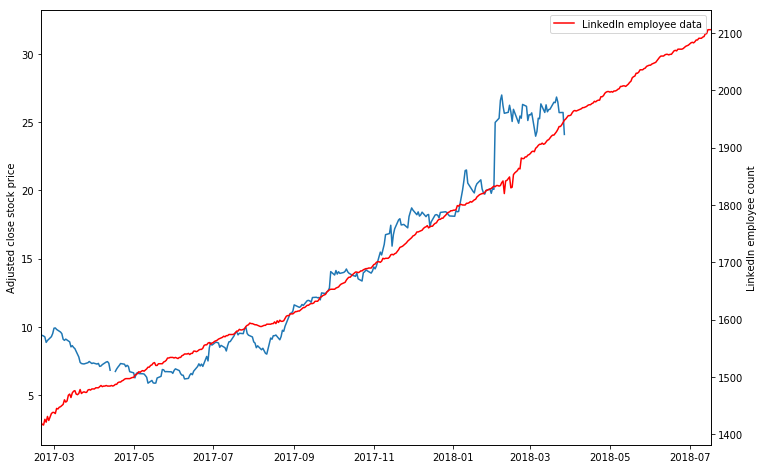

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlim(start,end)
ax.plot(USAK.index,USAK, label='Adjusted Close Price (USAK)')
ax.set_ylabel('Adjusted close stock price')
ax1=ax.twinx()
ax1.set_ylabel('LinkedIn employee count')
ax1.plot(USAK_link.index, USAK_link,color='r',label='LinkedIn employee data')
plt.legend();

I'll create a data loader so that I'm using consistent data later on.

In [7]:
# Function to format the data
def genX():
    X = pd.concat([USAK,USAK_link],axis=1)
    max_ = min(max(USAK.index), max(USAK_link.index))
    min_ = max(min(USAK.index), min(USAK_link.index))
    X.columns = ['close','emps']
    X = X.loc[min_:max_]
    X['y'] = X.close.shift(-1)
    X['y_emp'] = X.emps.shift(-1)
    X = X.interpolate()
    X['roll_mean'] = X.rolling(10).mean()['close']
    X['ewma'] = X.ewm(span=1.5).mean()['close']
    X = X.dropna()
    return X

In [9]:
X = genX()
X.head()

,close,emps,y,y_emp,roll_mean,ewma
2017-03-02,9.920000,1436.0,9.810000,1445.0,9.334000,9.898374
2017-03-03,9.810000,1445.0,9.746667,1444.0,9.382000,9.827675
2017-03-04,9.746667,1444.0,9.683333,1447.0,9.430667,9.762868
2017-03-05,9.683333,1447.0,9.620000,1448.0,9.513000,9.699240
2017-03-06,9.620000,1448.0,9.500000,1450.0,9.575000,9.635848


# Creating a Baseline Accuracy
In order to assess my models accuracy I wanted to generate some baseline predictions. Stock data tends to be significantly auto-correlated in time; the next stock price is closely related to the previous stock price. This can lead to overestimating the accuracy of our model.

In the below image you can see an example of a model that has learnt to predict the next timesteps by simply returning the value from the current timestep.
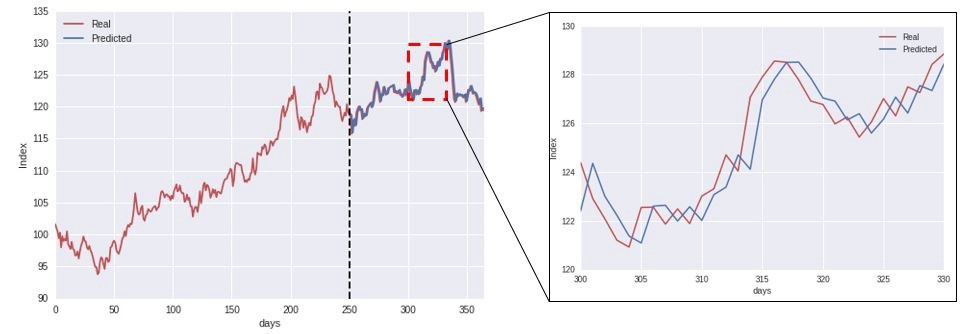
Figure: Pitfalls of predicting stock data [Source](https://www.kognifai.com/blog/avoid-the-pitfalls)

This is obviously not very helpful for predicting the stock market, hoever it can be used to create a baseline accuracy score to beat with our models. We will also use the daily difference in stock price as the targets in our model.

In [8]:
from sklearn.metrics import mean_absolute_error

In [10]:
# MAE of rolling mean
mean_absolute_error(X.y,X.roll_mean)

0.5213981244671756

In [11]:
# MAE of ewma
mean_absolute_error(X.y,X.ewma)

0.22268343392190765

In [12]:
# MAE of t-1
mean_absolute_error(X.y,X.close)

0.20744245524296678

The best performing naive model is simply using the current timestep to predict the next timestep. **Therefore for this dataset we will attempt to beat a MAE of 0.21**.


Below I have plotted these naive models against the target (y), which is the stock price for the next timestep.

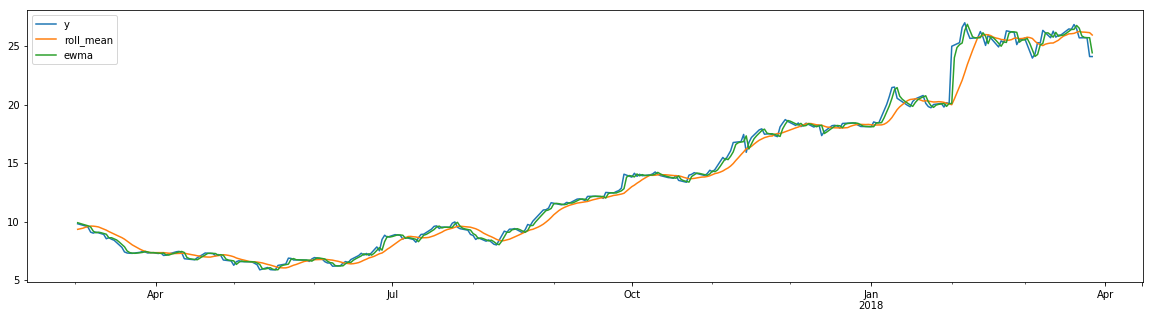

In [13]:
X[['y','roll_mean','ewma']].plot(figsize=(20,5));

## WaveNet Model
It is quite common to use recurrent neaural networks such as LSTMs to predict stock market values, however LSTMs struggle to model longer term patterns, which is a particular focus when comparing employment data to stock price. Therefore I decided to use a model based on the WaveNet acrchitechture from Google's DeepMind division.

WaveNet was designed to model audio data, but it should be useful in this case as well because of its ability to model long term patterns in time series data.

The specific advances that allow us to work with timeseries data are the use of Causal Convolutions, and Dilated Convolutions.

See the [DeepMind blogpost](https://deepmind.com/blog/wavenet-generative-model-raw-audio/) for a handy explaination of their architecture.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [15]:
# Implementation of causal convolutions in pytorch - this simply means that the network can only "see"
# data from previous timesteps, and can't peek into the future. The padding factor ensures this.
# source: https://github.com/pytorch/pytorch/issues/1333#issuecomment-400338207
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias)

    def forward(self, input):
        result = super(CausalConv1d, self).forward(input)
        if self.__padding != 0:
            return result[:, :, :-self.__padding]
        return result

In [16]:
# Definition of the simplified wavenet model
class WNet(nn.Module):
    def __init__(self):
        super(WNet, self).__init__()
        # Here we create a series of dilated convolutions that consider data further into the past
        self.convs = nn.Sequential(*[CausalConv1d(1,32,2)] + 
                                   [CausalConv1d(32,32,2,dilation=(2**i)) for i  in range(1,6)]) # was 8
        self.linear = nn.Sequential(
            nn.Linear(32,128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128,1),
        )
        
    def forward(self, input):
        output = self.convs(input)
        # In by default pytorch's linear models use the last dimension so I swap the dimensions
        # for the linear layers
        output = output.transpose(-1,1)
        output = self.linear(output).transpose(-1,1)
        return output

In [17]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('use gpu')
    dtype = torch.cuda.FloatTensor

    
def fit_model(num_epochs):
    WN = WNet()
    WN.to('cuda')
    WN.train()

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(WN.parameters(),lr=0.001)

    losses = []; #Initialize a variable to store losses

    X = Variable(torch.from_numpy(X_train.astype(np.float32))).unsqueeze(1).to('cuda')
    y = Variable(torch.from_numpy(y_train.astype(np.float32))).unsqueeze(1).to('cuda')

    for epoch in range(num_epochs):
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = WN(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item());

        if epoch % int(num_epochs/10) ==0 or epoch == num_epochs-1:
            print ('Epoch : %d/%d, Loss: %.4f' 
                   %(epoch+1, num_epochs, loss.item()))
    
    # Plot losses
    plt.plot(losses)
    
    return WN, losses

use gpu


## Predicting on a single timeseries

In [18]:
# Use this for predicting employment only
X = genX().diff()#.dropna()
y = X.y.values.reshape(-1,1)
X = X.close.values.reshape(-1,1)

cut0 = int(len(X)*0.1)
cut = int(len(X)*0.4)
cut1 = int(len(X)*0.6)
X_train,y_train = X[cut0:cut].T, y[cut0:cut].T
X_dev, y_dev = X[cut:cut1].T, y[cut:cut1].T

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((1, 117), (1, 117), (1, 78), (1, 78))

Epoch : 1/800, Loss: 0.1444
Epoch : 81/800, Loss: 0.0874
Epoch : 161/800, Loss: 0.0569
Epoch : 241/800, Loss: 0.0414
Epoch : 321/800, Loss: 0.0306
Epoch : 401/800, Loss: 0.0292
Epoch : 481/800, Loss: 0.0249
Epoch : 561/800, Loss: 0.0218
Epoch : 641/800, Loss: 0.0218
Epoch : 721/800, Loss: 0.0186
Epoch : 800/800, Loss: 0.0183


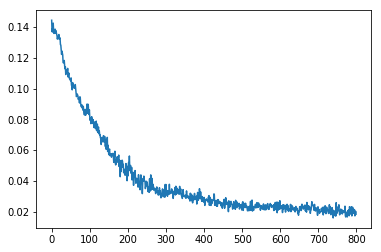

In [19]:
WN, losses = fit_model(num_epochs=800)

In [20]:
from sklearn.metrics import mean_absolute_error
WN.eval()

pred_dev = WN(torch.from_numpy(X_dev.astype(np.float32)).unsqueeze(1).to('cuda')).cpu().detach().numpy()
pred_dev = pred_dev.squeeze(1)

pred_train = WN(torch.from_numpy(X_train.astype(np.float32)).unsqueeze(1).to('cuda')).cpu().detach().numpy()
pred_train = pred_train.squeeze(1)

# Compare dev set error to expected error when curve following
print('Training Error:',mean_absolute_error(y_train,pred_train))
print('Dev. set Error:',mean_absolute_error(y_dev,pred_dev),'\nBaseline Error:',
      mean_absolute_error(y_dev,np.zeros(pred_dev.shape)))

Training Error: 0.014820556631285266
Dev. set Error: 0.22294840833172203 
Baseline Error: 0.15230769230769228


We can add back in the daily close values to see how our model is performing

0.10441568409403168


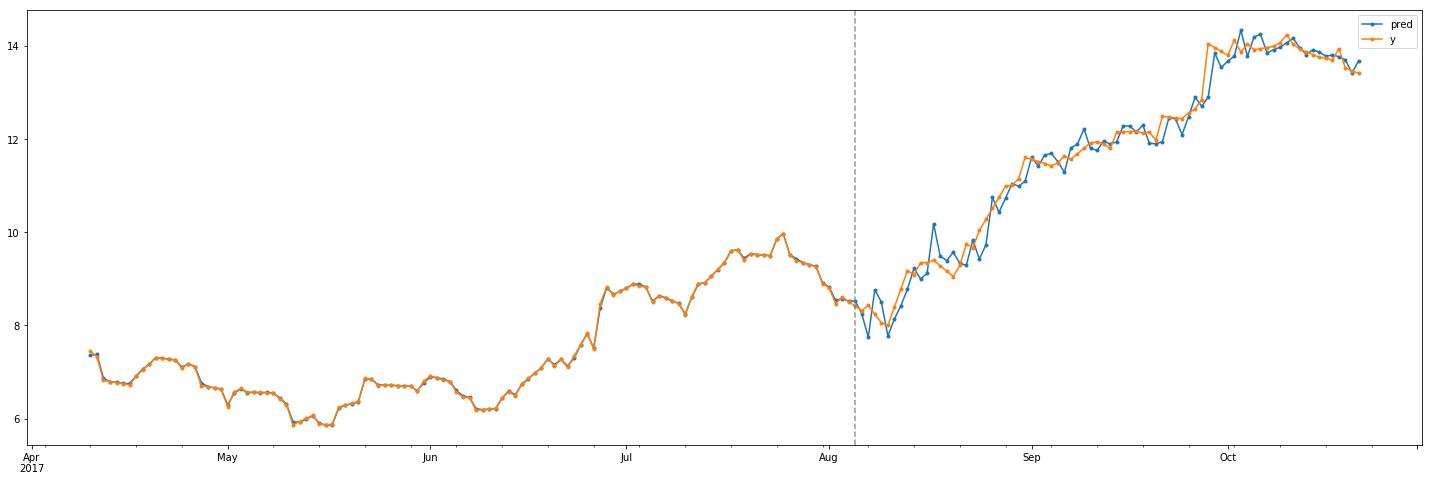

In [21]:
X = genX().diff()[cut0:cut1]
y = X.y
X = X.close

X = X.values.reshape(1,1,X.shape[0]).astype(np.float32)

pred = WN(torch.from_numpy(X).to('cuda')).cpu().detach().numpy()
pred = pred.ravel()

X = genX()[cut0:cut1]
y_ = X.y
X = X.close

pred = pd.Series(pred, index=y.index, name='pred')
df = pd.concat([pred,y_,X],axis=1)
df = df.dropna()
df['pred'] = df['pred'] + df['close']
df.drop('close',axis=1,inplace=True)
ax = df.plot(figsize=(25,8),marker='.')
ax.axvline(x=y.index[cut-cut0],c='grey',ls='--',alpha=0.8);

print(mean_absolute_error(df.y,df.pred))

We can see the network is highly accurate for the training data, but is worse than our baseline model for our development set.

## Predict employee and stock data at the same time

In [30]:
# Use this for predicting employment and stocks at same time
X = genX().diff()
y = X[['y','y_emp']].values
X = X[['close','emps']].values

cut0 = int(len(X)*0.1)
cut = int(len(X)*0.4)
cut1 = int(len(X)*0.6)

X_train,y_train = X[cut0:cut].T, y[cut0:cut].T
X_dev, y_dev = X[cut:cut1].T, y[cut:cut1].T

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((2, 117), (2, 117), (2, 78), (2, 78))

Epoch : 1/800, Loss: 0.7391
Epoch : 81/800, Loss: 0.4717
Epoch : 161/800, Loss: 0.3005
Epoch : 241/800, Loss: 0.2792
Epoch : 321/800, Loss: 0.2331
Epoch : 401/800, Loss: 0.2028
Epoch : 481/800, Loss: 0.1660
Epoch : 561/800, Loss: 0.1565
Epoch : 641/800, Loss: 0.1534
Epoch : 721/800, Loss: 0.1516
Epoch : 800/800, Loss: 0.1550


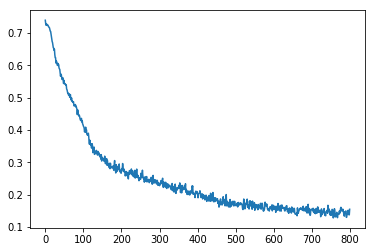

In [31]:
WN, losses = fit_model(num_epochs=800)

In [36]:
from sklearn.metrics import mean_absolute_error
WN.eval()

pred_dev = WN(torch.from_numpy(X_dev.astype(np.float32)).unsqueeze(1).to('cuda')).cpu().detach().numpy()
pred_dev = pred_dev.squeeze(1)

pred_train = WN(torch.from_numpy(X_train.astype(np.float32)).unsqueeze(1).to('cuda')).cpu().detach().numpy()
pred_train = pred_train.squeeze(1)

# Compare dev set error to expected error when curve following
print('Training Error:',mean_absolute_error(y_train,pred_train))
print('Dev. set Error:',mean_absolute_error(y_dev,pred_dev),'\nBaseline Error:',
      mean_absolute_error(y_dev,np.zeros(pred_dev.shape)))

Training Error: 0.12735236512237044
Dev. set Error: 1.0023454683623076 
Baseline Error: 0.8197435897435897


We can add back in the daily close values to see how our model is performing

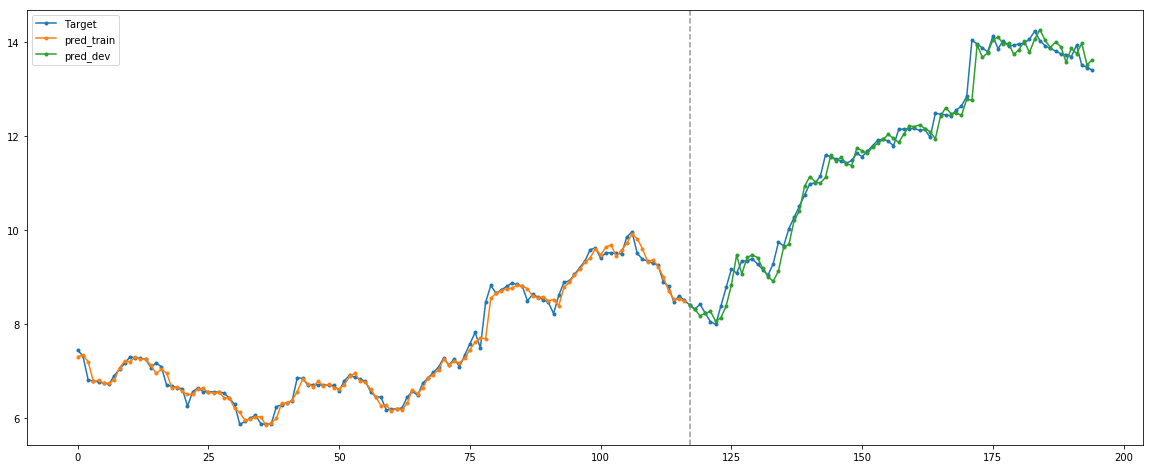

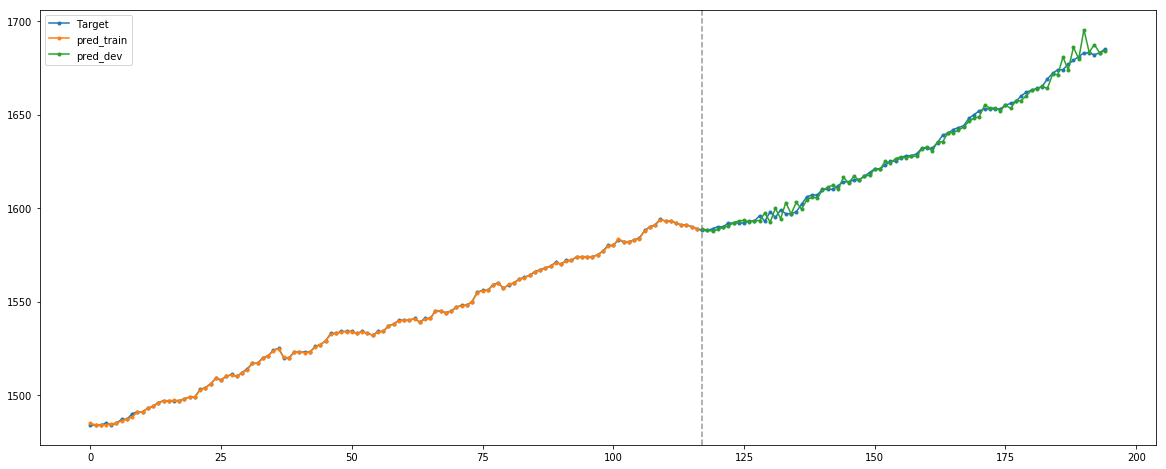

In [62]:
def plot_series(series_num=0):
    X = genX()[cut0:cut1]
    X = X[['close','emps']]

    prev = X.iloc[:,series_num].values

    target = pd.Series(np.concatenate((y_train, y_dev),axis=1)[series_num],name='Target') + prev
    train_pred = pd.Series(pred_train[series_num],name='pred_train',index=target.index[:len(pred_train[series_num])]) +\
                prev[:len(pred_train[series_num])]
    prediction = pd.Series(pred_dev[series_num],name='pred_dev',index=target.index[-len(pred_dev[series_num]):]) +\
                prev[-len(pred_dev[series_num]):]
    ax = pd.concat([target, train_pred, prediction],axis=1).plot(figsize=(20,8),marker='.')
    ax.axvline(x=len(target)-len(pred_dev[series_num]),c='grey',ls='--',alpha=0.8);

plot_series(0)
plot_series(1)

For both the stock price and employment data it looks like the network has learned to mimic the training set fairly well but seems to perform poorly on the development set.

## Predict All Stocks at the Same Time

In [63]:
# Predict all stocks at the same time
data = stocks.interpolate().fillna(0)[:-1]
X = data.diff()
y = X.shift(-1)[:-1].values
X = X.values

cut0 = int(len(X)*0.90)
cut = int(len(X)*0.925)
X_train,y_train = X[cut0:cut0+300].T, y[cut0:cut0+300].T
X_dev, y_dev = X[cut:cut+300].T, y[cut:cut+300].T

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((3199, 300), (3199, 300), (3199, 300), (3199, 300))

Epoch : 1/100, Loss: 0.7771
Epoch : 11/100, Loss: 0.7721
Epoch : 21/100, Loss: 0.7577
Epoch : 31/100, Loss: 0.7421
Epoch : 41/100, Loss: 0.7208
Epoch : 51/100, Loss: 0.7024
Epoch : 61/100, Loss: 0.6856
Epoch : 71/100, Loss: 0.6712
Epoch : 81/100, Loss: 0.6562
Epoch : 91/100, Loss: 0.6486
Epoch : 100/100, Loss: 0.6392


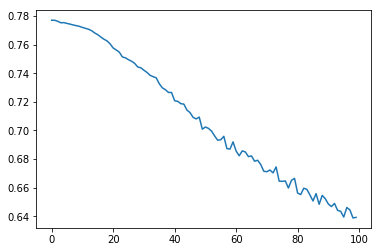

In [64]:
WN, losses = fit_model(num_epochs=100)

In [87]:
WN.eval()

pred_dev = WN(torch.from_numpy(X_dev.astype(np.float32)).unsqueeze(1).to('cuda')).cpu().detach().numpy()
pred_dev = pred_dev.squeeze(1)

pred_train = WN(torch.from_numpy(X_train.astype(np.float32)).unsqueeze(1).to('cuda')).cpu().detach().numpy()
pred_train = pred_train.squeeze(1)

# Compare dev set error to expected error when curve following
print('Training Error:',mean_absolute_error(y_train,pred_train))
print('Dev. set Error:',mean_absolute_error(y_dev,pred_dev),'\nBaseline Error:',
      mean_absolute_error(y_dev,np.zeros(pred_dev.shape)))

Training Error: 0.32850575038364926
Dev. set Error: 1.0818545069013328 
Baseline Error: 15.724999999999998


Similarly above we see we're fitting the training set well, but we're not doing as well on the development set.

## Predict N steps in Future
We can modify the above network to predict the next N timesteps instaed of predicting only the current timesteps.

In [88]:
class WNet(nn.Module):
    def __init__(self):
        super(WNet, self).__init__()
        self.convs = nn.Sequential(*[CausalConv1d(1,32,2)] + 
                                   [CausalConv1d(32,32,2,dilation=(2**i)) for i  in range(1,6)]) # was 8
        self.linear = nn.Sequential(
            nn.Linear(32,128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128,1),
        )
        
    def forward(self, input):
        output = self.convs(input)
        output = output.transpose(-1,1)
        output = self.linear(output).transpose(-1,1)
        return output[:,:,-14:] # We modify this net to only ouput N=14 timesteps.

In [100]:
# Use this for predicting employment only N days in advance
N = 14
encode_len = 200
start = 30
X = genX().diff()#.dropna()
y = X.y.values.reshape(-1,1)
X = X.close.values.reshape(-1,1)

cut0 = N + start
cut1 = encode_len + start
cut2 = N + encode_len + start
cut3 = N + encode_len + N + start

X_train,y_train = X[start:cut1].T, X[cut1:cut2].T
X_dev, y_dev = X[cut0:cut2].T, X[cut2:cut3].T

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((1, 200), (1, 14), (1, 200), (1, 14))

Epoch : 1/100, Loss: 0.1656
Epoch : 11/100, Loss: 0.1537
Epoch : 21/100, Loss: 0.1463
Epoch : 31/100, Loss: 0.1261
Epoch : 41/100, Loss: 0.0892
Epoch : 51/100, Loss: 0.0743
Epoch : 61/100, Loss: 0.0612
Epoch : 71/100, Loss: 0.0272
Epoch : 81/100, Loss: 0.0344
Epoch : 91/100, Loss: 0.0342
Epoch : 100/100, Loss: 0.0227


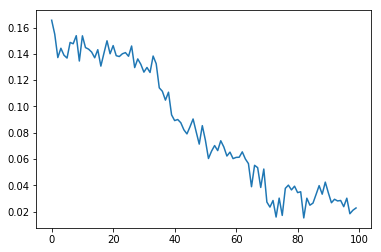

In [102]:
WN, losses = fit_model(num_epochs=100)

In [108]:
WN.eval()

pred_dev = WN(torch.from_numpy(X_dev.astype(np.float32)).unsqueeze(1).to('cuda')).cpu().detach().numpy()
pred_dev = pred_dev.squeeze(1)

pred_train = WN(torch.from_numpy(X_train.astype(np.float32)).unsqueeze(1).to('cuda')).cpu().detach().numpy()
pred_train = pred_train.squeeze(1)

# Compare dev set error to expected error when curve following
print('Training Error:',mean_absolute_error(y_train,pred_train))
print('Dev. set Error:',mean_absolute_error(y_dev,pred_dev),'\nBaseline Error:',
      mean_absolute_error(y_dev,np.zeros(pred_dev.shape)))

Training Error: 0.017767550278277762
Dev. set Error: 0.34978535199094385 
Baseline Error: 0.2892857142857145


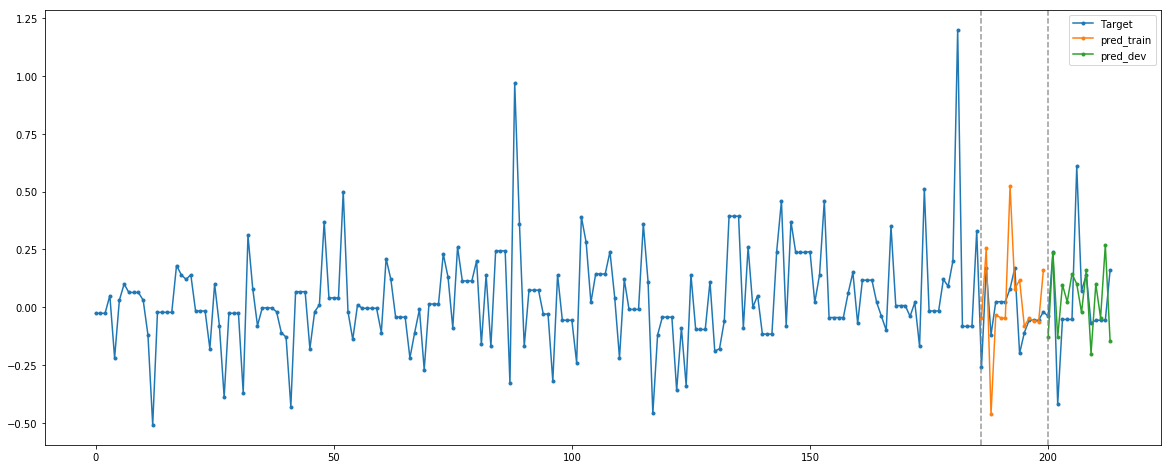

In [109]:
series_num=0
target = pd.Series(np.concatenate((X_train, y_train),axis=1)[series_num],name='Target')
train_pred = pd.Series(pred_train[series_num],name='pred_train',index=target.index[-28:-14])
prediction = pd.Series(pred_dev[series_num],name='pred_dev',index=target.index[-14:])
ax = pd.concat([target, train_pred, prediction],axis=1).plot(figsize=(20,8),marker='.')
ax.axvline(x=len(target)-28,c='grey',ls='--',alpha=0.8);
ax.axvline(x=len(target)-14,c='grey',ls='--',alpha=0.8);